<a href="https://colab.research.google.com/github/ghanbarifereshteh/singlecolorprj/blob/main/noisysinglecolornew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from PIL import Image
from numpy import asarray
import shutil
import os

In [3]:
#generate original data
#generate 3 random number and then create a 180*180 image(with single color)
from PIL import Image
def createimage(numberOfimg,sizeOfImage):
  for i in range(numberOfimg):
    red = np.random.choice(range(256), size=1)
    green = np.random.choice(range(256), size=1)
    blue = np.random.choice(range(256), size=1)
    img = Image.new('RGB', (sizeOfImage, sizeOfImage), (red[0], green[0], blue[0]))
    img.save(str(i)+".jpg")

In this notebook, we have a function that generates images with noises. we send the percent of the noise we want, so the images are created.and also this function creates 7 folders and classifies data.

In [4]:
def get_color_name(rgb):
  colors = {
    "red": (255, 0, 0),
    "green": (0, 255, 0),
    "blue": (0, 0, 255),
    "yellow": (255, 255, 0),
    "magenta": (255, 0, 255),
    "cyan": (0, 255, 255),
    "black": (0, 0, 0),
    "white": (255, 255, 255)
  }
  min_distance = float("inf")
  closest_color = None
  for color, value in colors.items():
    distance = sum([(i - j) ** 2 for i, j in zip(rgb, value)])
    if distance < min_distance:
        min_distance = distance
        closest_color = color
  return closest_color

In [5]:
#create image whith percent% noise
def createNoisyImage(numberOfImages,sizeOfImage,percent):
  folder = ""
  label = 0
  sum = 0
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)
  labels_noisy = []
  for i in range(0,numberOfImages):
    #before applying noises, we must distinguish the color
    name = str(i)+".jpg"
    img = Image.open(name)
    numpydata_noisy[i] = asarray(img)
    red = numpydata_noisy[i][0][0][0]
    green = numpydata_noisy[i][0][0][1]
    blue = numpydata_noisy[i][0][0][2]
    color = list(np.random.choice(range(256), size=3))
    color = (red,green,blue)
    folder = get_color_name(color)
    labels_noisy.append(folder)
    noiseColor=list(np.random.choice(range(256), size=3));
    for j in range(0,sizeOfImage*percent) :
        x=np.random.choice(range(100))
        y=np.random.choice(range(100))
        img.putpixel((x,y), (noiseColor[0], noiseColor[1], noiseColor[2]))
        #plt.imshow(img)
    newName = "noise"+str(percent)+str(i)+".jpg"
    if not os.path.exists("/content/"+folder):
      # if the demo_folder directory is not present
      # then create it.
      os.makedirs("/content/"+folder)
    img.save("/content/"+folder+"/"+newName)
    numpydata_noisy[i] = asarray(img)
  return labels_noisy,numpydata_noisy

for start creating data and training run codes below.
we first remove any folder in the root.because the training model use the folders in the directory path as classes.


In [19]:
rm -rf *

In [23]:
ls

we create 1000 images as a single color dataset.

In [24]:
createimage(3000,100)

and then make them noisy.

In [25]:
(labels_test,numpydata_test) = createNoisyImage(3000,100,0)

<ipython-input-5-1659f6911308>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpydata_noisy = np.empty([numberOfImages, sizeOfImage, sizeOfImage, 3], dtype=np.int)


In [ ]:
after creating noisy images, please go further to start training.
And for creating noisy images with other percent of noise, run the corresponding command bellow. be carefull to remove remaining folders.

6


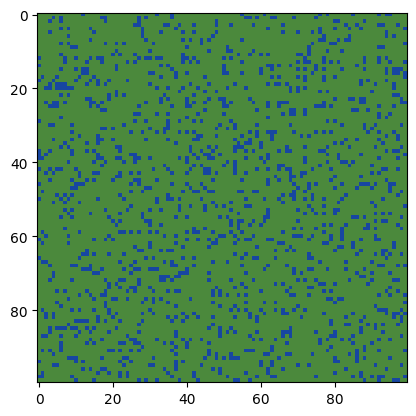

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(numpydata_test[141])
print(labels_test[141])

when you want to create iamges with 25% noises

In [ ]:
rm -rf noisy*

In [ ]:
(labels_test,numpydata_test) = createNoisyImage(1000,100,25)

In [ ]:
ls

noise25938.jpg


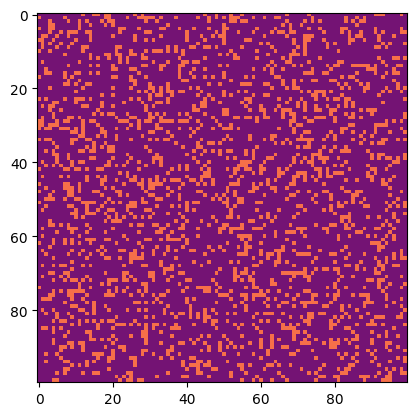

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(numpydata_test[938])

In [ ]:
rm -rf noisy*

In [ ]:
(labels_test,numpydata_test) = createNoisyImage(1000,100,45)

In [ ]:
cd noisygreen15/

/content/noisygreen15


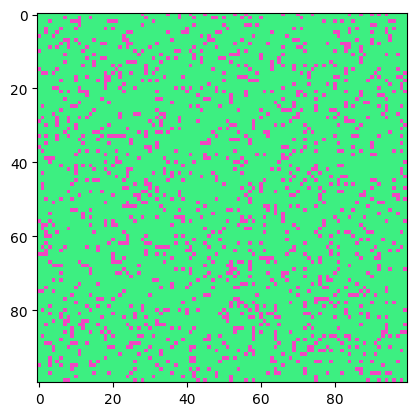

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(numpydata_test[987])

In [13]:
import pathlib
current_working_directory = os.getcwd()
data_dir = pathlib.Path(current_working_directory)
print(data_dir)

/content


In [26]:
batch_size = 32
img_height = 100
img_width = 100

In [33]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 8 classes.
Using 600 files for validation.


In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 8 classes.
Using 2400 files for training.


In [103]:
class_names = val_ds.class_names

In [48]:
!ls -1 white|wc -l

364


In [132]:
from tensorflow.keras import datasets, layers, models
num_classes = len(class_names)
model = models.Sequential()
#layers.Rescaling(1./255, input_shape=(100, 100, 3)),
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [134]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

In [ ]:
model.summary()


In [135]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)
epochs = 100
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,shuffle='true',callbacks=[callback])
#history = model.fit(numpydata_test, labels_test, epochs=10)

Epoch 1/100
75/75 [==============================] - 4s 19ms/step - loss: 6.7401 - acc: 0.3988 - val_loss: 1.3391 - val_acc: 0.4950
Epoch 2/100
75/75 [==============================] - 2s 21ms/step - loss: 1.2520 - acc: 0.5396 - val_loss: 2.0714 - val_acc: 0.5200
Epoch 3/100
75/75 [==============================] - 2s 20ms/step - loss: 1.1750 - acc: 0.5587 - val_loss: 1.2115 - val_acc: 0.6483
Epoch 4/100
75/75 [==============================] - 1s 14ms/step - loss: 0.9486 - acc: 0.6671 - val_loss: 1.0812 - val_acc: 0.6150
Epoch 5/100
75/75 [==============================] - 1s 17ms/step - loss: 0.9182 - acc: 0.6654 - val_loss: 0.8716 - val_acc: 0.6683
Epoch 6/100
75/75 [==============================] - 1s 14ms/step - loss: 0.8354 - acc: 0.6908 - val_loss: 0.8961 - val_acc: 0.6683
Epoch 7/100
75/75 [==============================] - 1s 15ms/step - loss: 0.7864 - acc: 0.6917 - val_loss: 0.7511 - val_acc: 0.6867
Epoch 8/100
75/75 [==============================] - 1s 16ms/step - loss: 0.

we can test some of our data. the image with number 141 was drawn an its label is 6. lets see that how out network predict its color.

In [ ]:
import numpy as np
model(numpydata_test)[141]
np.argmax(model(numpydata_test)[141])

6

In [ ]:
import numpy as np
model(numpydata_test)[722]
print(model(numpydata_test)[722])
np.argmax(model(numpydata_test)[722])

tf.Tensor(
[ 2.6114063  -4.4213905  -6.195866   -0.10071872  0.29045317  1.2520814
  2.730952   -5.4395328  -3.6727228  -5.4016643 ], shape=(10,), dtype=float32)


6

now we test an image of another color. those image are blue and were predicted correctly.

In [ ]:
print(model(numpydata_test)[366])
np.argmax(model(numpydata_test)[366])

tf.Tensor(
[ 21.352667  -32.844677  -43.38867    -1.4409175   1.6609558  12.937952
  19.052536  -38.42757   -26.717478  -39.21145  ], shape=(10,), dtype=float32)


0

this image is red and was predicted correctly inspite of noises made on it.

In [ ]:
class_names = val_ds.class_names
print(class_names)

['.config', 'noisyblack15', 'noisyblue15', 'noisygreen15', 'noisypurple15', 'noisyred15', 'noisywhite15', 'noisyyellow15', 'sample_data']


result of validation on images with 15% noises

Epoch 1/10
32/32 [==============================] - 2s 14ms/step - loss: 23.3167 - acc: 0.5580
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 1.1656 - acc: 0.5690
Epoch 3/10
32/32 [==============================] - 0s 13ms/step - loss: 0.9001 - acc: 0.5720
Epoch 4/10
32/32 [==============================] - 0s 14ms/step - loss: 0.9191 - acc: 0.6100
Epoch 5/10
32/32 [==============================] - 0s 14ms/step - loss: 1.4659 - acc: 0.4780
Epoch 6/10
32/32 [==============================] - 0s 14ms/step - loss: 1.4780 - acc: 0.6610
Epoch 7/10
32/32 [==============================] - 0s 14ms/step - loss: 1.2863 - acc: 0.6870
Epoch 8/10
32/32 [==============================] - 1s 16ms/step - loss: 1.1594 - acc: 0.6840
Epoch 9/10
32/32 [==============================] - 0s 13ms/step - loss: 0.9598 - acc: 0.6970
Epoch 10/10
32/32 [==============================] - 0s 13ms/step - loss: 0.8754 - acc: 0.6960


result of validation on images with 25% noises

Epoch 1/10
32/32 [==============================] - 2s 14ms/step - loss: 50.5913 - acc: 0.5270
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 1.1217 - acc: 0.6170
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.7228 - acc: 0.7160
Epoch 4/10
32/32 [==============================] - 0s 12ms/step - loss: 0.6273 - acc: 0.7380
Epoch 5/10
32/32 [==============================] - 0s 13ms/step - loss: 0.6090 - acc: 0.7480
Epoch 6/10
32/32 [==============================] - 0s 13ms/step - loss: 0.5925 - acc: 0.7560
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.5152 - acc: 0.7970
Epoch 8/10
32/32 [==============================] - 0s 13ms/step - loss: 0.4877 - acc: 0.8060
Epoch 9/10
32/32 [==============================] - 0s 13ms/step - loss: 0.6852 - acc: 0.7500
Epoch 10/10
32/32 [==============================] - 0s 13ms/step - loss: 0.5254 - acc: 0.7950

result of validation on images with 45% noises

Epoch 1/10
32/32 [==============================] - 3s 16ms/step - loss: 29.4900 - acc: 0.3580
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 1.2315 - acc: 0.4990
Epoch 3/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1706 - acc: 0.4840
Epoch 4/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1235 - acc: 0.4900
Epoch 5/10
32/32 [==============================] - 0s 14ms/step - loss: 1.1577 - acc: 0.4790
Epoch 6/10
32/32 [==============================] - 0s 13ms/step - loss: 2.0312 - acc: 0.3690
Epoch 7/10
32/32 [==============================] - 0s 13ms/step - loss: 1.8527 - acc: 0.3870
Epoch 8/10
32/32 [==============================] - 0s 12ms/step - loss: 1.6437 - acc: 0.3980
Epoch 9/10
32/32 [==============================] - 0s 13ms/step - loss: 1.4801 - acc: 0.3980
Epoch 10/10
32/32 [==============================] - 0s 13ms/step - loss: 1.3650 - acc: 0.3980


In [ ]:
rm -rf tf

In [60]:
epochs_range = callback.stopped_epoch + 1
print(epochs_range)

13


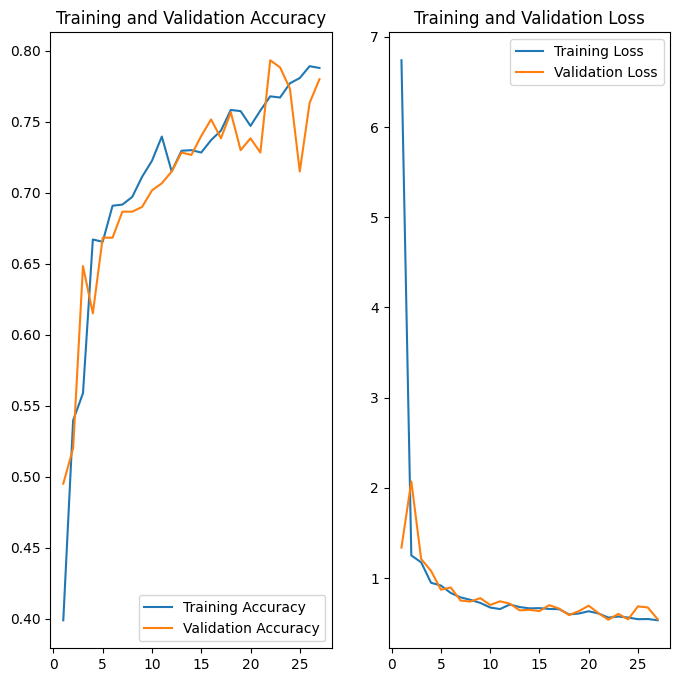

In [136]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#test_loss, test_acc = model.evaluate(numpydata_test,  labels_test, verbose=2)